## 1. Carga del dataset y selección de variables numéricas

En esta sección cargamos nuevamente el archivo `Cleaned_Featured_Dataset.csv` y seleccionamos **solo las variables numéricas** que usaremos para la interpretabilidad:

- Longitudes, conteos de palabras, proporción de mayúsculas.
- Conteo de dígitos, caracteres especiales.
- `urgency_score`, `email_count`, `url_count`, `urls`.

La idea es entrenar un modelo de **Random Forest** sobre estas features y luego explicar sus decisiones con **importancia de variables** y **SHAP values**.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap

print("Cargando dataset limpio con features...")
data = pd.read_csv("Cleaned_Featured_Dataset.csv")
print("Filas:", len(data))

# ====================================================
# 1. SELECCIONAR SOLO FEATURES NUMÉRICAS
# ====================================================

numeric_features = [
    "subject_len", "body_len",
    "subject_words", "body_words",
    "subject_upper", "body_upper",
    "digits_count", "special_chars",
    "urgency_score", "email_count", "url_count",
    "urls"   # <- tu columna original, también es numérica
]

X = data[numeric_features]
y = data["label"]

print("\nShapes:")
print("X:", X.shape)
print("y:", y.shape)

Cargando dataset limpio con features...
Filas: 10706

Shapes:
X: (10706, 12)
y: (10706,)


## 2. División train/test y entrenamiento de Random Forest

Dividimos los datos en entrenamiento y prueba (80/20) y entrenamos un **Random Forest** con parámetros fijos:

- `n_estimators = 300`
- `max_depth = 20`
- `min_samples_split = 2`
- `min_samples_leaf = 1`

Este modelo ya está **tuneado** con hiperparámetros razonables (basados en experimentos previos) y lo usamos como modelo principal para interpretabilidad.

In [2]:
# ====================================================
# 2. TRAIN / TEST SPLIT
# ====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ====================================================
# 3. RANDOM FOREST PARA INTERPRETABILIDAD
# ====================================================

print("\nEntrenando RandomForest...")
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Entrenando RandomForest...

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       819
           1       0.94      0.93      0.93      1323

    accuracy                           0.92      2142
   macro avg       0.91      0.92      0.91      2142
weighted avg       0.92      0.92      0.92      2142



## 3. Importancia global de variables (feature importance)

Calculamos la **importancia de características** reportada por el Random Forest:

- Nos indica qué variables contribuyen más a la reducción de impureza en los árboles.
- Ordenamos las features de mayor a menor importancia.
- Guardamos el resultado en `Feature_Importance_RF.csv` para usarlo en el informe y en otras herramientas (por ejemplo, Excel o Power BI).

Esta es una **visión global** de qué atributos son más relevantes para distinguir correos legítimos y de phishing.


In [3]:
# ====================================================
# 4. IMPORTANCIA DE FEATURES
# ====================================================

importances = pd.DataFrame({
    "feature": numeric_features,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\nIMPORTANCIA DE VARIABLES:")
print(importances)

importances.to_csv("Feature_Importance_RF.csv", index=False)


IMPORTANCIA DE VARIABLES:
          feature  importance
10      url_count    0.198138
8   urgency_score    0.125384
5      body_upper    0.123147
4   subject_upper    0.116579
7   special_chars    0.091146
1        body_len    0.078739
3      body_words    0.070201
6    digits_count    0.053526
0     subject_len    0.044826
2   subject_words    0.039922
11           urls    0.035563
9     email_count    0.022828


## 4. Interpretabilidad local con SHAP values

Para complementar la importancia de variables, utilizamos **SHAP (SHapley Additive exPlanations)**:

- SHAP asigna a cada feature una contribución **local** a la predicción de cada ejemplo.
- Entrenamos un `TreeExplainer` sobre el Random Forest.
- Calculamos los `shap_values` para el conjunto de prueba.
- Generamos un **SHAP summary plot**, que muestra:
  - Qué variables son más importantes.
  - Cómo se distribuyen sus efectos (positivos/negativos) sobre la probabilidad de phishing.

Este análisis nos ayuda a explicar **por qué** el modelo toma ciertas decisiones en ejemplos concretos.



Calculando valores SHAP (esto puede tardar un poco)...
Generando SHAP summary plot...

Interpretabilidad COMPLETA.
 - Archivo guardado: Feature_Importance_RF.csv


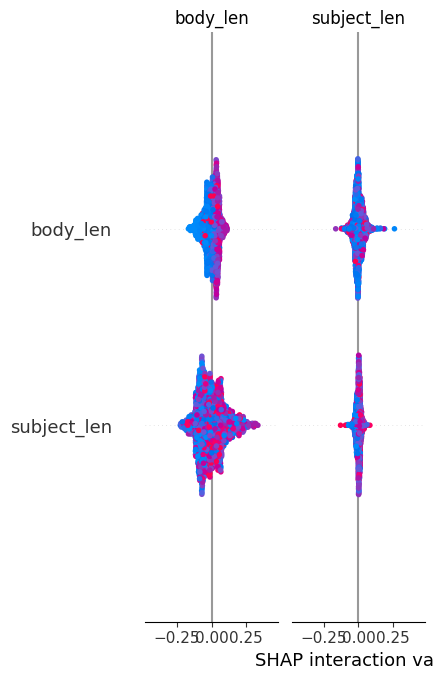

In [6]:
# ====================================================
# 5. INTERPRETABILIDAD SHAP
# ====================================================

print("\nCalculando valores SHAP (esto puede tardar un poco)...")

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Compatibilidad: SHAP a veces regresa lista (binario) o solo un array 2D
if isinstance(shap_values, list):
    # Binario: tomamos la clase 1 (phishing)
    shap_to_plot = shap_values[1]
else:
    # Ya es matriz (n_samples, n_features) o con una col extra
    shap_to_plot = shap_values

# A veces SHAP devuelve una columna extra (bias/offset). Si hay una más que en X, la recortamos.
if shap_to_plot.shape[1] == X_test.shape[1] + 1:
    shap_to_plot = shap_to_plot[:, :-1]

print("Generando SHAP summary plot...")
shap.summary_plot(shap_to_plot, X_test, show=False)

print("\nInterpretabilidad COMPLETA.")
print(" - Archivo guardado: Feature_Importance_RF.csv")
